# model Gaussain distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model

import utils

/home/sven/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
lookback = 10
hidden_neurons = 300
model = load_model('../LSTM_{}_{}.model'.format(lookback, hidden_neurons))

In [3]:
val1 = pd.read_csv('../val1_treated.csv', index_col=0)
val1X, val1Y = utils.createDataset(val1, lookback)

In [4]:
val1X.shape

(11117, 10, 13)

In [5]:
pred = model.predict(val1X)
error_vectors = pred - val1Y

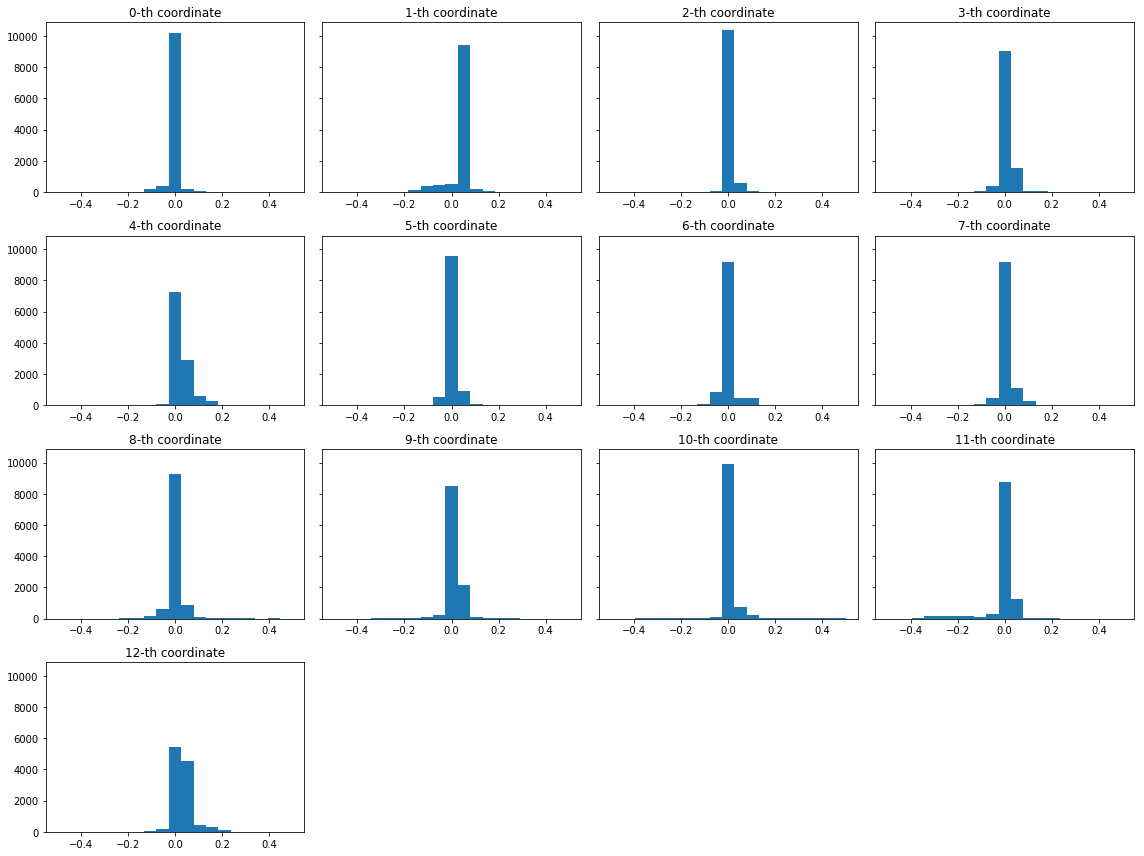

In [6]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors.shape[1]:
        ax.remove()
    else:
        ax.hist(error_vectors[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

In [11]:
avg = error_vectors.mean(axis=0)
cov = np.cov(error_vectors.T)

In [12]:
cov_inv = np.linalg.inv(cov)
cov_det = np.linalg.det(cov)

In [13]:
def gaussian(x):
    k = x.shape[-1]
    f = lambda x: np.exp(-.5 * (np.array(x)-avg).dot(cov_inv).dot(np.array(x)-avg)) / np.sqrt(cov_det * np.power(2*np.pi, k))
    x = np.array(x)
    if x.ndim == 1:
        return f(x)
    else:
        return np.array([f(v) for v in x])

# determine optimal threshold of likelihood

In [14]:
val2 = pd.read_csv('../val2_treated.csv', index_col=0)
vala = pd.read_csv('../vala_treated.csv', index_col=0)

In [15]:
val2X, val2Y = utils.createDataset(val2, lookback)
error_vectors_n = model.predict(val2X) - val2Y

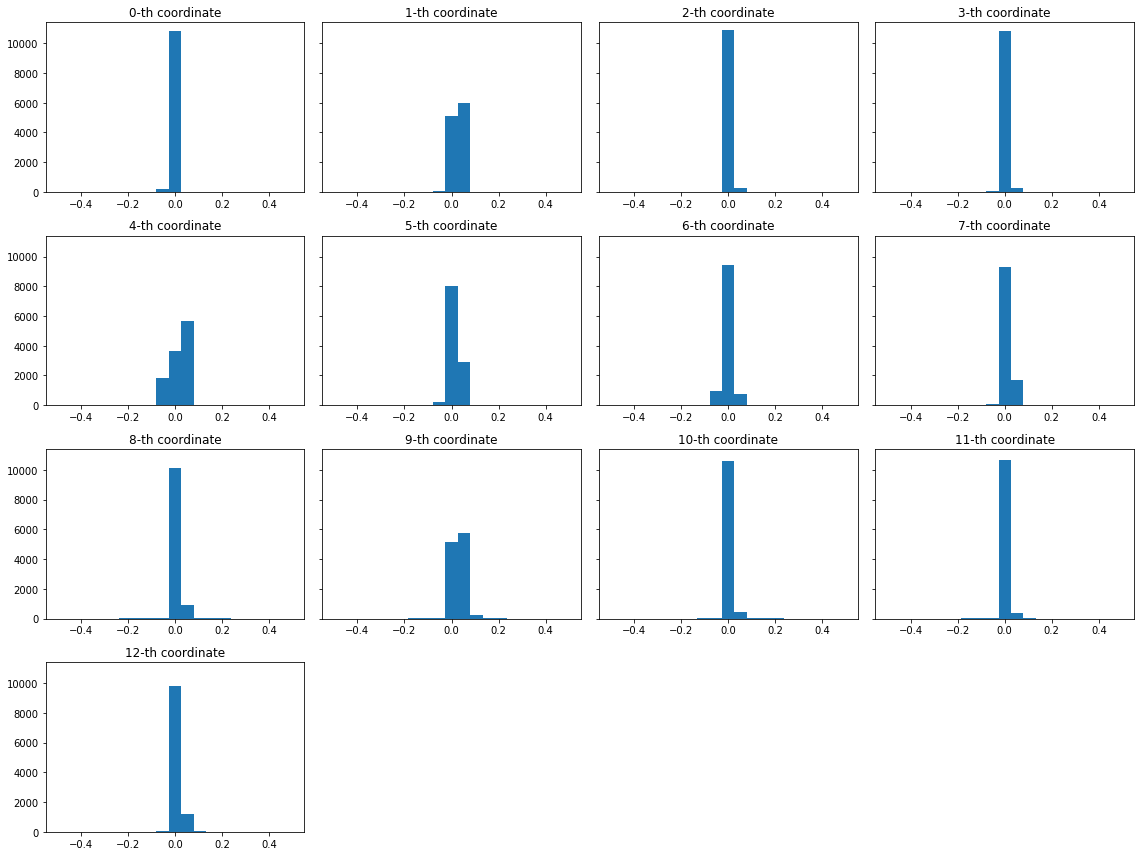

In [17]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors_n.shape[1]:
        ax.remove()
    else:
        ax.hist(error_vectors_n[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

In [18]:
error_vectors_a = []
vala_broken = utils.getBrokens(vala.index)
for i in range(len(vala_broken)-1):
    valaX, valaY = utils.createSequnces(vala.iloc[vala_broken[i]+20-lookback:vala_broken[i+1]-20, :], lookback)
    if len(valaY) == 0:
        continue
    predY_a = model.predict(np.array(valaX))
    errors_a = predY_a - np.array(valaY)
    error_vectors_a += list(errors_a)
error_vectors_a = np.array(error_vectors_a)

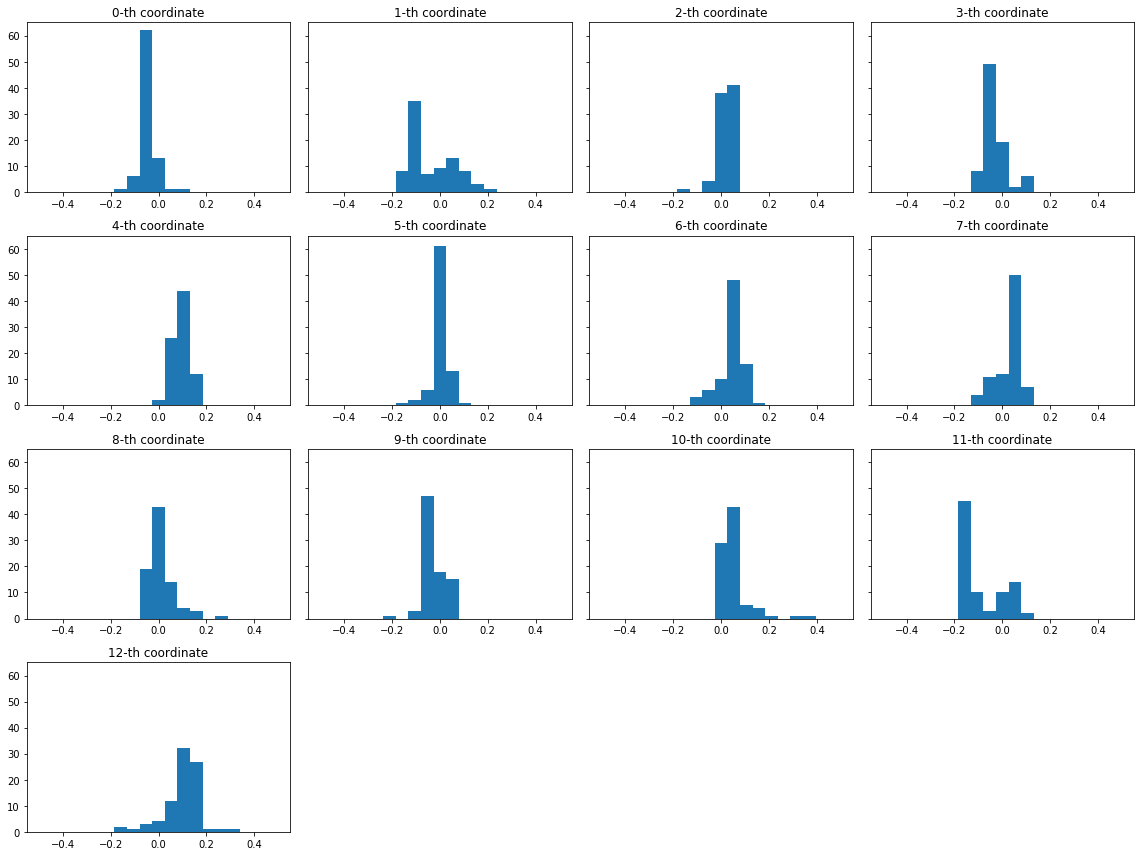

In [19]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors_a.shape[1]:
        ax.remove()
    else:
        ax.hist(error_vectors_a[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

In [20]:
likelihood_n = gaussian(error_vectors_n)
likelihood_a = gaussian(error_vectors_a)

In [21]:
y_true = np.array([0] * len(likelihood_n) + [1] * len(likelihood_a))
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [22]:
likelihood_total = -np.concatenate((likelihood_n, likelihood_a))
likelihood_total

array([-4.29445962e+15, -4.34750067e+15, -4.31968205e+15, ...,
       -1.42852747e+06, -5.71448955e+06, -1.79256742e+06])

In [23]:
a = y_true[np.argsort(likelihood_total)]

In [24]:
likelihood_total.max()

-7.407021965834958e-67

In [25]:
arg_sorted = np.argsort(likelihood_total)[::-1]
y_true_sort = np.array(y_true)[arg_sorted]
prob_sort = np.array(likelihood_total)[arg_sorted]

In [26]:
beta = 1
p_best, r_best, f1_best, ts = 0, 0, 0, 0
num_ones = sum(y_true)
count = 1
for i, label in enumerate(y_true_sort):
    if label == 1.:
        count += 1
    p = count / (i+1)
    r = count / num_ones
    f1 = (1 + beta**2) * p * r / ((beta**2) * p + r)        
    if f1 > f1_best:
        p_best = p
        r_best = r
        f1_best = f1
        ts = prob_sort[i]

p_best, r_best, f1_best, ts

(0.14478764478764478,
 0.8928571428571429,
 0.2491694352159468,
 -765187613.0537531)

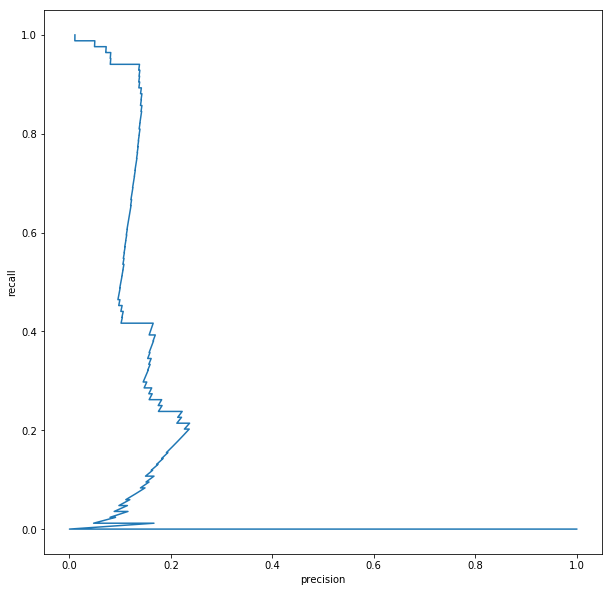

In [27]:
from sklearn.metrics import precision_recall_curve

p_trace, r_trace, _ = precision_recall_curve(y_true, likelihood_total)

plt.figure(figsize=(10, 10))
plt.plot(p_trace, r_trace)
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()

# testing

In [28]:
testn = pd.read_csv('../testn_treated.csv', index_col=0)
testa = pd.read_csv('../testa_treated.csv', index_col=0)

In [29]:
testnX, testnY = utils.createDataset(testn, lookback)
error_testn = model.predict(testnX) - testnY

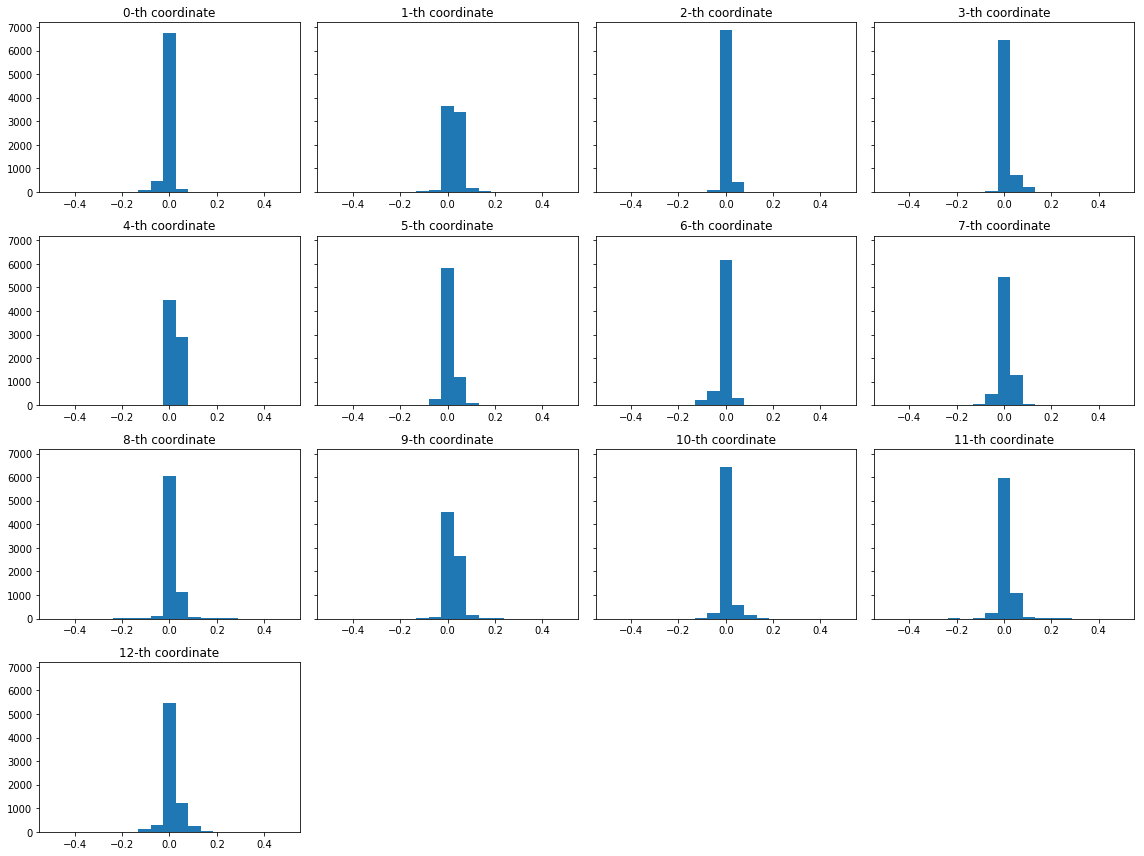

In [30]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_testn.shape[1]:
        ax.remove()
    else:
        ax.hist(error_testn[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

In [31]:
error_testa = []
testa_broken = utils.getBrokens(testa.index)
for i in range(len(testa_broken)-1):
    testaX, testaY = utils.createSequnces(testa.iloc[testa_broken[i]+20-lookback:testa_broken[i+1]-20, :], lookback)
    if len(testaY) == 0:
        continue
    predY_a = model.predict(np.array(testaX))
    errors_a = predY_a - np.array(testaY)
    error_testa += list(errors_a)
error_testa = np.array(error_testa)

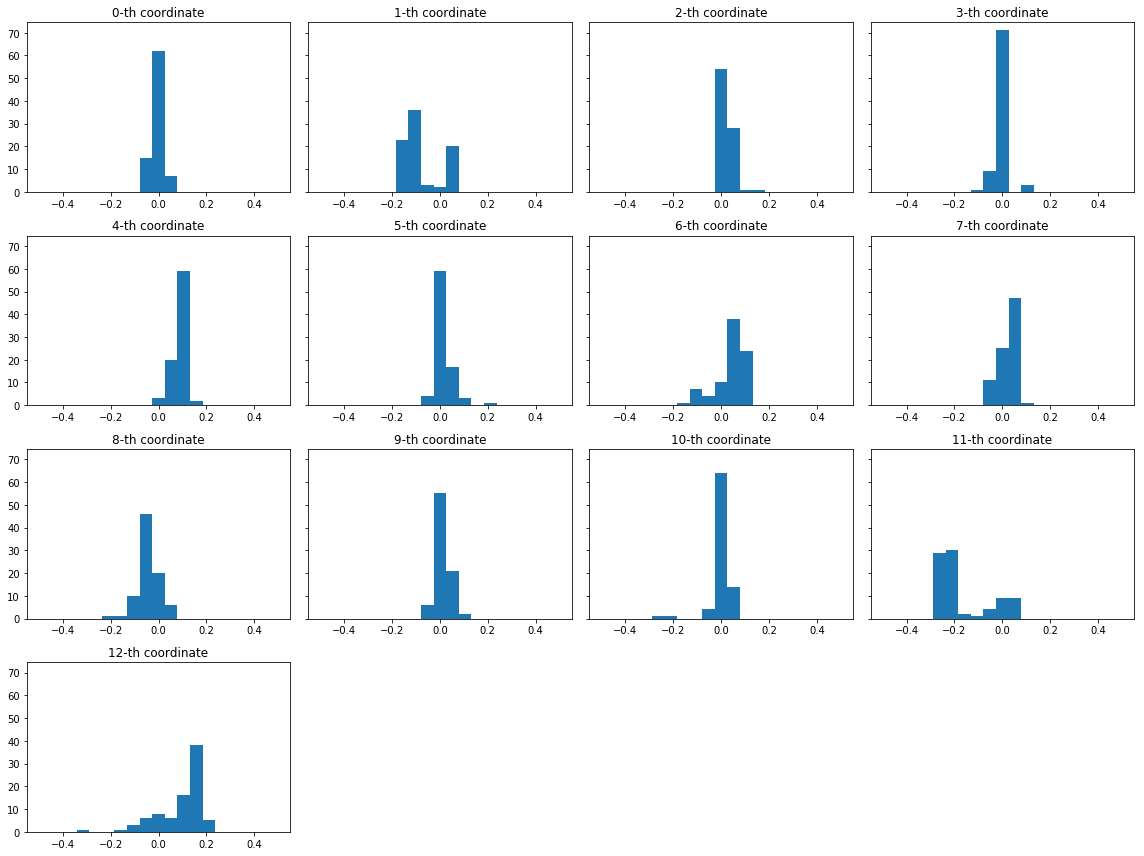

In [32]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors_a.shape[1]:
        ax.remove()
    else:
        ax.hist(error_testa[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

In [33]:
likelihood_testn = gaussian(error_testn)
likelihood_testa = gaussian(error_testa)

In [34]:
y_true = np.array([0] * len(likelihood_n) + [1] * len(likelihood_a))
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [39]:
likelihood_total = -np.concatenate((likelihood_n, likelihood_a))
y_pred = np.array([0 if prob < ts else 1 for prob in likelihood_total])

In [40]:
from sklearn.metrics import precision_recall_fscore_support

In [42]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
precision, recall, fscore

(0.14285714285714285, 0.8809523809523809, 0.24584717607973425)